# 05 — XAI + Explanation Consistency Metrics

**Mục tiêu:**
- Compute Integrated Gradients (IG) attributions cho EN, ES, FR
- Measure explanation consistency:
  - **CTAM (CyberTerm Attribution Mass)**: tỉ lệ attribution tập trung vào cyber/domain terms
  - **Top-k Cyber Token Overlap**: Jaccard overlap của cyber tokens trong top-k attributions
- Case studies: explanation drift examples

**Lý do quan trọng cho paper:**
- Prediction robustness chỉ đo "model có đúng không", nhưng không giải thích "model dựa vào gì"
- Explanation consistency đo "model có dùng cùng rationale không" → insight quan trọng cho security/CTI

In [16]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import sys

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import LayerIntegratedGradients
from tqdm.auto import tqdm

# Add utils
sys.path.insert(0, str(Path.cwd()))
from utils import (
    compute_ctam,
    top_k_cyber_overlap,
    aggregate_subword_attributions,
    extract_cyber_tokens
)

print('torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())

torch: 2.5.1
CUDA available: True


## 1) Config

In [17]:
# Paths
DATA_PATH = Path('translation_eval/test_with_predictions.csv')  # or val_with_predictions.csv
MODEL_DIR = Path('model_output/final_model')
OUTPUT_DIR = Path('xai_results')
OUTPUT_DIR.mkdir(exist_ok=True)

# XAI config
XAI_SAMPLE_SIZE = 200  
TOP_K = 10  # top-k tokens for overlap metric
MAX_LENGTH = 128

# Force CPU (PyTorch CPU-only version installed to avoid CUDA DLL issues)
DEVICE = 'cuda'
print(f'Device: {DEVICE}')
print(f'Analyzing {XAI_SAMPLE_SIZE} samples. Expected time: ~15-20 minutes on CPU.')

Device: cuda
Analyzing 200 samples. Expected time: ~15-20 minutes on CPU.


## 2) Load data

In [18]:
df = pd.read_csv(DATA_PATH)
print('Data shape:', df.shape)

# Sample for XAI (stratified by label)
if len(df) > XAI_SAMPLE_SIZE:
    df_xai = df.groupby('label_id', group_keys=False).apply(
        lambda x: x.sample(min(XAI_SAMPLE_SIZE // df['label_id'].nunique(), len(x)), random_state=42)
    ).reset_index(drop=True)
else:
    df_xai = df.copy()

print(f'XAI sample size: {len(df_xai)}')
print('Label distribution:')
display(df_xai['label_id'].value_counts())

Data shape: (1998, 8)
XAI sample size: 198
Label distribution:


C:\Users\Nguyen Ngo\AppData\Local\Temp\ipykernel_2964\3970594479.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xai = df.groupby('label_id', group_keys=False).apply(


label_id
0    66
1    66
2    66
Name: count, dtype: int64

## 3) Load model

In [19]:
tokenizer = AutoTokenizer.from_pretrained(str(MODEL_DIR))
model = AutoModelForSequenceClassification.from_pretrained(str(MODEL_DIR)).to(DEVICE)
model.eval()

print(f'✅ Model loaded')
print(f'Num labels: {model.config.num_labels}')

✅ Model loaded
Num labels: 3


In [20]:
# Verify model loaded correctly
print(f'Model on device: {next(model.parameters()).device}')

Model on device: cuda:0


## 4) Integrated Gradients setup

In [21]:
# IG attribution layer: use embedding layer
# Update: model.bert (not distilbert) since we're using bert-base-multilingual-cased

# Wrapper to extract logits for Captum
def forward_func(inputs):
    """Wrapper that returns only logits (tensor) instead of SequenceClassifierOutput"""
    return model(inputs).logits

lig = LayerIntegratedGradients(forward_func, model.bert.embeddings)

def compute_attributions(text, target_label):
    """
    Compute IG attributions for a single text.
    Returns: tokens (list), attributions (np.array)
    """
    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    ).to(DEVICE)
    
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    # Compute IG
    attributions = lig.attribute(
        inputs=input_ids,
        target=target_label,
        n_steps=30,  # reduced from 50 for faster computation
        internal_batch_size=1
    )
    
    # Sum across embedding dimension
    attributions_sum = attributions.sum(dim=-1).squeeze(0)
    attributions_sum = attributions_sum.cpu().detach().numpy()
    
    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    
    # Filter by attention mask (remove padding)
    mask = attention_mask.squeeze().cpu().numpy().astype(bool)
    tokens = [t for t, m in zip(tokens, mask) if m]
    attributions_sum = attributions_sum[mask]
    
    return tokens, attributions_sum

## 5) Compute attributions for EN, ES, FR

In [22]:
results = []

for idx, row in tqdm(df_xai.iterrows(), total=len(df_xai), desc='Computing IG'):
    # Use 'cleaned_text' (actual column name from CSV)
    text_en = row.get('cleaned_text', row.get('clean_text', row.get('text', '')))
    text_es = row['text_es']
    text_fr = row['text_fr']
    
    pred_en = int(row['pred_en'])
    pred_es = int(row['pred_es'])
    pred_fr = int(row['pred_fr'])
    
    label_true = int(row['label_id'])
    
    # Compute attributions for EN
    try:
        tokens_en, attr_en = compute_attributions(text_en, pred_en)
        # Aggregate subwords to words
        words_en, attr_words_en = aggregate_subword_attributions(tokens_en, attr_en)
        
        # Compute CTAM
        ctam_en = compute_ctam(words_en, attr_words_en, lang='en')
        
    except Exception as e:
        print(f'Error at index {idx} (EN): {e}')
        continue
    
    # Compute attributions for ES
    try:
        tokens_es, attr_es = compute_attributions(text_es, pred_es)
        words_es, attr_words_es = aggregate_subword_attributions(tokens_es, attr_es)
        ctam_es = compute_ctam(words_es, attr_words_es, lang='es')
    except Exception as e:
        print(f'Error at index {idx} (ES): {e}')
        continue
    
    # Compute attributions for FR
    try:
        tokens_fr, attr_fr = compute_attributions(text_fr, pred_fr)
        words_fr, attr_words_fr = aggregate_subword_attributions(tokens_fr, attr_fr)
        ctam_fr = compute_ctam(words_fr, attr_words_fr, lang='fr')
    except Exception as e:
        print(f'Error at index {idx} (FR): {e}')
        continue
    
    # Compute overlap metrics
    overlap_en_es = top_k_cyber_overlap(
        words_en, attr_words_en,
        words_es, attr_words_es,
        k=TOP_K, lang_tgt='es'
    )
    
    overlap_en_fr = top_k_cyber_overlap(
        words_en, attr_words_en,
        words_fr, attr_words_fr,
        k=TOP_K, lang_tgt='fr'
    )
    
    # Store results
    results.append({
        'index': idx,
        'label_true': label_true,
        'pred_en': pred_en,
        'pred_es': pred_es,
        'pred_fr': pred_fr,
        'ctam_en': ctam_en,
        'ctam_es': ctam_es,
        'ctam_fr': ctam_fr,
        'ctam_drift_es': ctam_en - ctam_es,
        'ctam_drift_fr': ctam_en - ctam_fr,
        'overlap_jaccard_es': overlap_en_es['jaccard'],
        'overlap_jaccard_fr': overlap_en_fr['jaccard'],
        'overlap_count_es': overlap_en_es['overlap_count'],
        'overlap_count_fr': overlap_en_fr['overlap_count'],
    })

df_results = pd.DataFrame(results)
print(f'\n✅ IG computation complete: {len(df_results)} samples')

Computing IG:   0%|          | 0/198 [00:00<?, ?it/s]

Computing IG: 100%|██████████| 198/198 [11:37<00:00,  3.52s/it]


✅ IG computation complete: 198 samples


## 6) CTAM drift analysis

In [23]:
print('CTAM statistics:')
display(df_results[['ctam_en', 'ctam_es', 'ctam_fr', 'ctam_drift_es', 'ctam_drift_fr']].describe())

# Mean drift
mean_drift_es = df_results['ctam_drift_es'].mean()
mean_drift_fr = df_results['ctam_drift_fr'].mean()

print(f'\nMean CTAM drift:')
print(f'  EN→ES: {mean_drift_es:+.4f}')
print(f'  EN→FR: {mean_drift_fr:+.4f}')

# Save CTAM results
ctam_summary = pd.DataFrame({
    'metric': ['mean_ctam_en', 'mean_ctam_es', 'mean_ctam_fr', 'mean_drift_es', 'mean_drift_fr'],
    'value': [
        df_results['ctam_en'].mean(),
        df_results['ctam_es'].mean(),
        df_results['ctam_fr'].mean(),
        mean_drift_es,
        mean_drift_fr
    ]
})
ctam_summary.to_csv(OUTPUT_DIR / 'ctam_summary.csv', index=False)
print(f'\n✅ CTAM summary saved')

CTAM statistics:


,ctam_en,ctam_es,ctam_fr,ctam_drift_es,ctam_drift_fr
count,198.000000,198.000000,198.000000,198.000000,198.000000
mean,0.009029,0.013646,0.017079,-0.004617,-0.008050
std,0.057096,0.039296,0.062241,0.060324,0.054870
min,-0.175691,-0.069783,-0.072935,-0.240862,-0.281838
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.444689,0.169673,0.477488,0.392882,0.193536



Mean CTAM drift:
  EN→ES: -0.0046
  EN→FR: -0.0081

✅ CTAM summary saved


## 7) Overlap analysis

In [24]:
print('\nTop-k cyber token overlap statistics:')
display(df_results[['overlap_jaccard_es', 'overlap_jaccard_fr', 'overlap_count_es', 'overlap_count_fr']].describe())

mean_jaccard_es = df_results['overlap_jaccard_es'].mean()
mean_jaccard_fr = df_results['overlap_jaccard_fr'].mean()

print(f'\nMean Jaccard overlap (top-{TOP_K}):')
print(f'  EN→ES: {mean_jaccard_es:.4f}')
print(f'  EN→FR: {mean_jaccard_fr:.4f}')

# Save overlap results
overlap_summary = pd.DataFrame({
    'metric': ['mean_jaccard_es', 'mean_jaccard_fr'],
    'value': [mean_jaccard_es, mean_jaccard_fr]
})
overlap_summary.to_csv(OUTPUT_DIR / 'overlap_summary.csv', index=False)
print(f'✅ Overlap summary saved')


Top-k cyber token overlap statistics:


,overlap_jaccard_es,overlap_jaccard_fr,overlap_count_es,overlap_count_fr
count,198.000000,198.000000,198.000000,198.000000
mean,0.861279,0.860606,0.116162,0.111111
std,0.343720,0.337110,0.336662,0.330786
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,2.000000,2.000000



Mean Jaccard overlap (top-10):
  EN→ES: 0.8613
  EN→FR: 0.8606
✅ Overlap summary saved


## 8) Save full results

In [25]:
df_results.to_csv(OUTPUT_DIR / 'xai_full_results.csv', index=False)
print(f'✅ Full XAI results saved to {OUTPUT_DIR / "xai_full_results.csv"}')

✅ Full XAI results saved to xai_results\xai_full_results.csv


## 9) Case studies: high drift examples

In [26]:
# Find top-3 high CTAM drift examples (EN→ES)
high_drift_es = df_results.nlargest(3, 'ctam_drift_es')

print('\n' + '='*80)
print('CASE STUDIES: High CTAM drift (EN→ES)')
print('='*80)

for i, (_, row) in enumerate(high_drift_es.iterrows(), 1):
    idx = int(row['index'])
    original_row = df_xai.loc[idx]
    
    print(f'\nCase {i}:')
    print(f'  Index: {idx}')
    print(f'  True label: {row["label_true"]}  |  Pred EN: {row["pred_en"]}  |  Pred ES: {row["pred_es"]}')
    print(f'  CTAM EN: {row["ctam_en"]:.4f}  |  CTAM ES: {row["ctam_es"]:.4f}  |  Drift: {row["ctam_drift_es"]:+.4f}')
    print(f'  Overlap Jaccard: {row["overlap_jaccard_es"]:.4f}')
    print(f'  Text EN: {original_row.get("cleaned_text", original_row.get("clean_text", original_row.get("text", "")))[:150]}...')
    print(f'  Text ES: {original_row["text_es"][:150]}...')


CASE STUDIES: High CTAM drift (EN→ES)

Case 1:
  Index: 78
  True label: 1.0  |  Pred EN: 1.0  |  Pred ES: 1.0
  CTAM EN: 0.4447  |  CTAM ES: 0.0518  |  Drift: +0.3929
  Overlap Jaccard: 0.0000
  Text EN: XSS vulnerability exploited....
  Text ES: Vulnerabilidad XSS explotada....

Case 2:
  Index: 81
  True label: 1.0  |  Pred EN: 1.0  |  Pred ES: 1.0
  CTAM EN: 0.2657  |  CTAM ES: 0.0544  |  Drift: +0.2113
  Overlap Jaccard: 0.2000
  Text EN: Ransomware vulnerability exploited....
  Text ES: Explotación de vulnerabilidad de ransomware....

Case 3:
  Index: 77
  True label: 1.0  |  Pred EN: 1.0  |  Pred ES: 1.0
  CTAM EN: 0.2248  |  CTAM ES: 0.0313  |  Drift: +0.1936
  Overlap Jaccard: 0.0000
  Text EN: Phishing breached our corporate_network. Test kitchen series such book close production....
  Text ES: Phishing violó nuestra red corporativa. Prueba series de cocina tal libro cerrar la producción....


## 10) Visualization: CTAM distribution

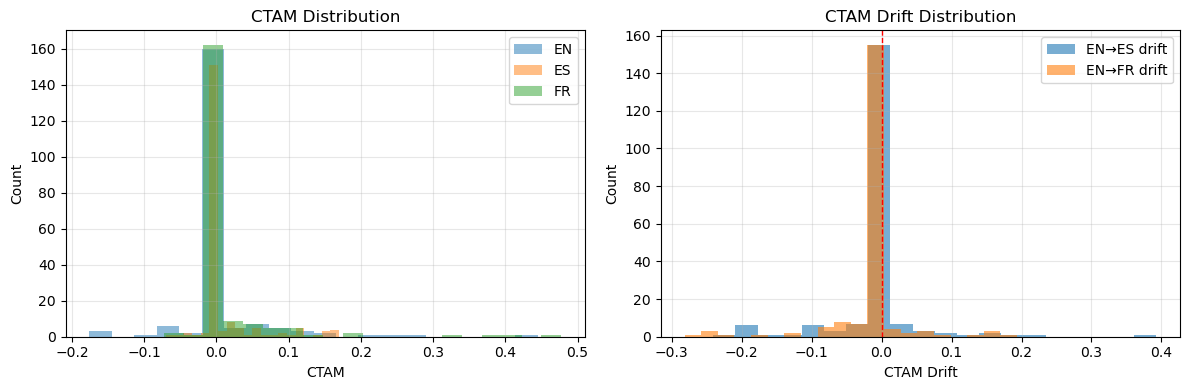


✅ CTAM visualization saved


In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# CTAM distribution
axes[0].hist(df_results['ctam_en'], bins=20, alpha=0.5, label='EN')
axes[0].hist(df_results['ctam_es'], bins=20, alpha=0.5, label='ES')
axes[0].hist(df_results['ctam_fr'], bins=20, alpha=0.5, label='FR')
axes[0].set_xlabel('CTAM')
axes[0].set_ylabel('Count')
axes[0].set_title('CTAM Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# CTAM drift
axes[1].hist(df_results['ctam_drift_es'], bins=20, alpha=0.6, label='EN→ES drift')
axes[1].hist(df_results['ctam_drift_fr'], bins=20, alpha=0.6, label='EN→FR drift')
axes[1].axvline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('CTAM Drift')
axes[1].set_ylabel('Count')
axes[1].set_title('CTAM Drift Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'ctam_distribution.png', dpi=150)
plt.show()

print(f'\n✅ CTAM visualization saved')

---
## Summary for paper

**Key findings to report:**
1. **Prediction robustness** (from notebook 04):
   - Accuracy/F1 drop EN→ES/FR
   - Label flip rate

2. **Explanation consistency** (from this notebook):
   - Mean CTAM drift: measures if model still focuses on cyber/domain cues
   - Top-k overlap: measures if important tokens are consistent
   - Case studies: examples of high drift (qualitative analysis)

3. **Implications:**
   - Multilingual robustness is not just about accuracy
   - Explanation drift matters for trust/interpretability in security contexts
   - Cyber terms may be preserved better (or worse) across languages

**Next:** Write paper sections 6-7 (Results & Discussion) using these metrics.